In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

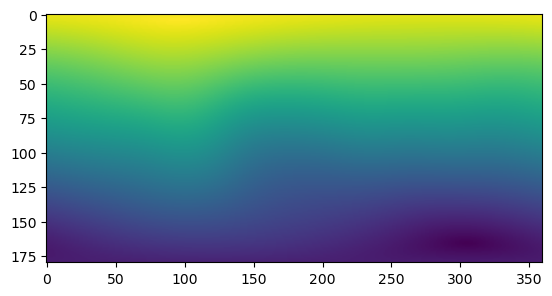

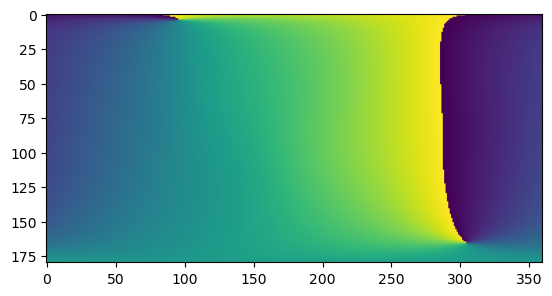

In [2]:
file_dir = "/home/jupyter/data/quasi_dipole/"
file_path_lat = os.path.join(file_dir, "qd_lat_2025.npy")
file_path_lon = os.path.join(file_dir, "qd_lon_2025.npy")
lat = np.load(file=file_path_lat)
lon = np.load(file=file_path_lon)
plt.imshow(lat)
plt.show()
plt.imshow(lon)
plt.show()

In [3]:
lat.min()

np.float64(-89.78302764892578)

In [4]:
standard = lambda x: (x - x.min()) / (x.max() - x.min())

In [16]:
np.deg2rad(90)

np.float64(1.5707963267948966)

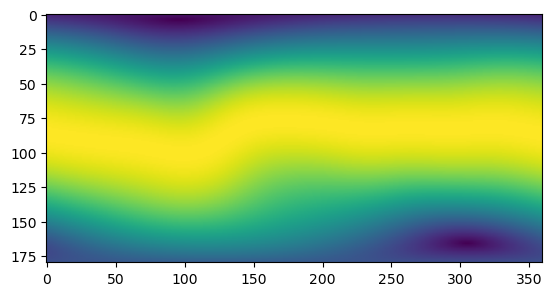

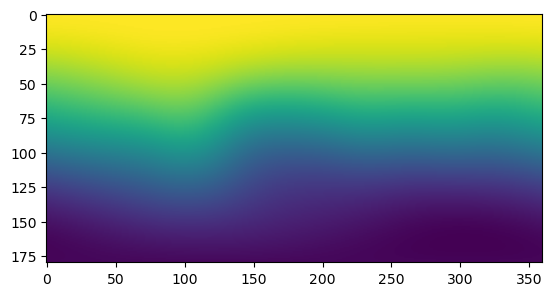

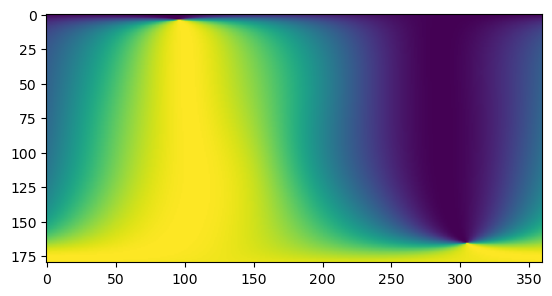

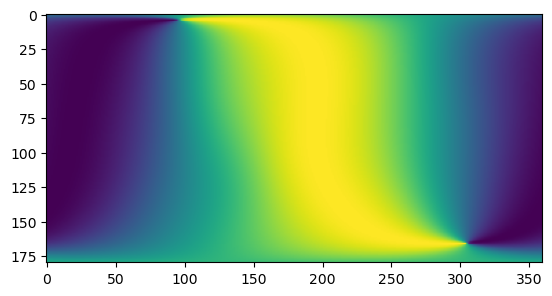

In [21]:
k = 1

plt.imshow(np.cos(k * np.deg2rad(lat)))
plt.show()
plt.imshow(np.sin(k * np.deg2rad(lat)))
plt.show()
plt.imshow(np.cos(k * np.deg2rad(lon)))
plt.show()
plt.imshow(np.sin(k * np.deg2rad(lon)))
plt.show()

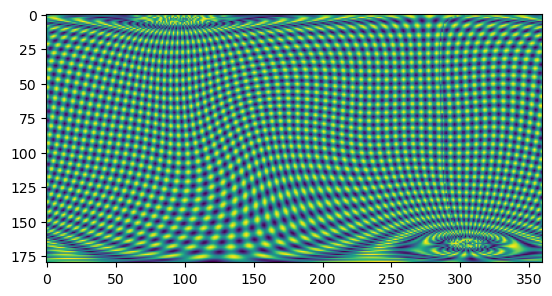

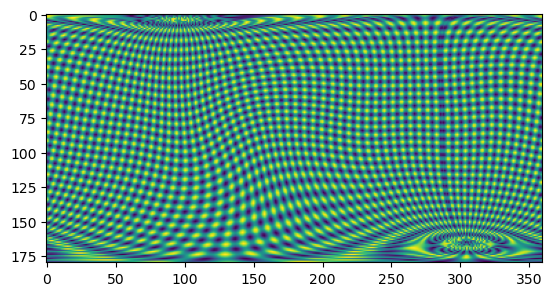

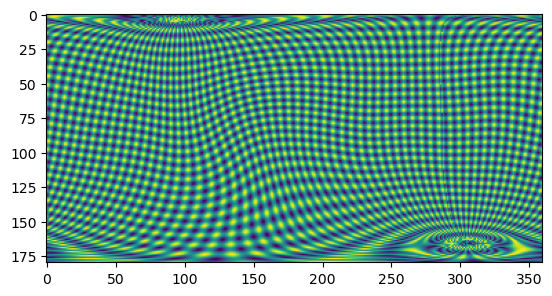

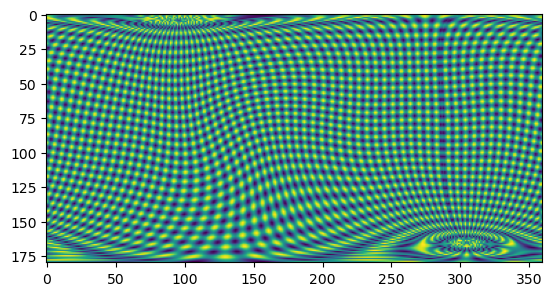

In [6]:
plt.imshow(np.cos(lat)+np.sin(lon))
plt.show()
plt.imshow(np.sin(lat)+np.cos(lon))
plt.show()
plt.imshow(np.sin(lat)+np.sin(lon))
plt.show()
plt.imshow(np.cos(lat)+np.cos(lon))
plt.show()

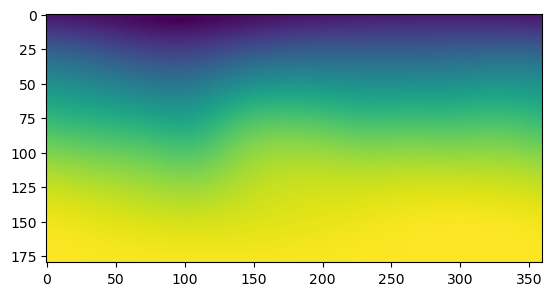

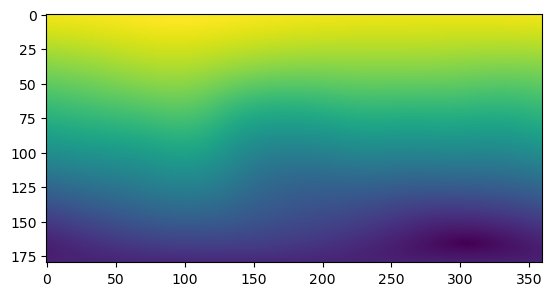

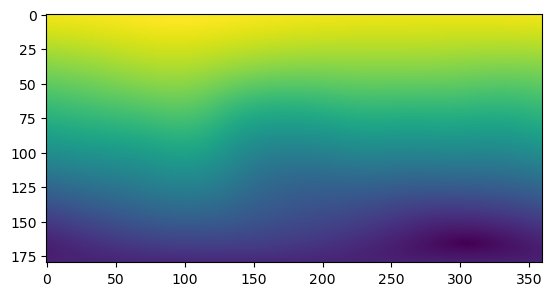

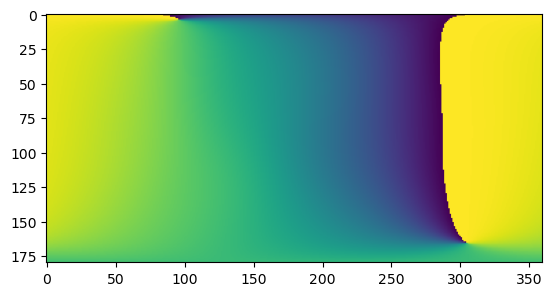

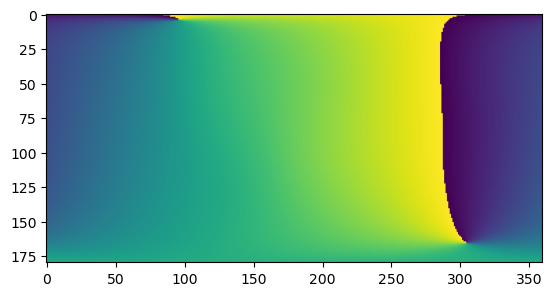

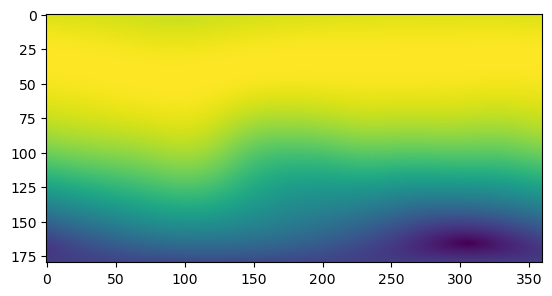

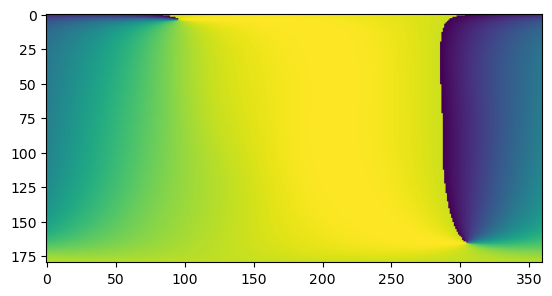

In [7]:
plt.imshow(np.cos(standard(lat)))
plt.show()
plt.imshow(np.sin(standard(lat)))
plt.show()
plt.imshow(np.sin(standard(lat)))
plt.show()
plt.imshow(np.cos(standard(lon)))
plt.show()
plt.imshow(np.sin(standard(lon)))
plt.show()
plt.imshow(np.cos(standard(lat)) + np.sin(standard(lat)))
plt.show()
plt.imshow(np.cos(standard(lon)) + np.sin(standard(lon)))
plt.show()

In [ ]:
import numpy as np
import torch

def make_positional_channels(lat_grid_deg, lon_grid_deg, K=4, include_tangent=True):
    """
    lat_grid_deg, lon_grid_deg: arrays shape (H, W) in degrees
    returns: tensor (C, H, W) of channels
    """
    lat = np.deg2rad(lat_grid_deg)
    lon = np.deg2rad(lon_grid_deg)
    coslat = np.cos(lat)
    sinlat = np.sin(lat)
    coslon = np.cos(lon)
    sinlon = np.sin(lon)

    # 3D unit vector
    x = coslat * coslon
    y = coslat * sinlon
    z = sinlat

    channels = [x, y, z]

    # cell area proxy
    channels.append(coslat)  # shape H,W

    # Fourier features
    for k in range(1, K+1):
        channels.append(np.sin(k * lat))
        channels.append(np.cos(k * lat))
        channels.append(np.sin(k * lon))
        channels.append(np.cos(k * lon))

    # Optional local tangent basis (east, north) in 3D
    if include_tangent:
        # north tangent: derivative of unit vector wrt lat (not normalized)
        north_x = -sinlat * coslon
        north_y = -sinlat * sinlon
        north_z = coslat
        # east tangent: derivative of unit vector wrt lon (not normalized)
        east_x = -coslat * sinlon
        east_y =  coslat * coslon
        east_z = np.zeros_like(lat)

        # Normalize tangents to unit length (avoid zeros)
        n_norm = np.sqrt(north_x**2 + north_y**2 + north_z**2) + 1e-12
        e_norm = np.sqrt(east_x**2 + east_y**2 + east_z**2) + 1e-12

        channels += [north_x / n_norm, north_y / n_norm, north_z / n_norm,
                     east_x / e_norm,  east_y / e_norm,  east_z / e_norm]

    arr = np.stack(channels, axis=0).astype(np.float32)  # (C, H, W)
    return torch.from_numpy(arr)

# Example usage for 180x360 quasi-dipole lat-lon grid:
H, W = 180, 360
# You likely already have corresponding quasi-dipole lat/lon arrays; if not:
lat_grid = np.linspace(89.5, -89.5, H)[:,None] * np.ones((1,W))   # center-of-cell lat
lon_grid = np.linspace(-179.5, 179.5, W)[None,:] * np.ones((H,1)) # center-of-cell lon

channels = make_positional_channels(lat, lon, K=4, include_tangent=True)
print(channels.shape)  # e.g. (3 + 1 + 4*4 + 6 = 26, H, W)


torch.Size([26, 180, 360])


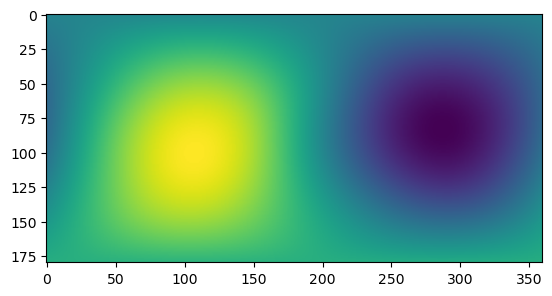

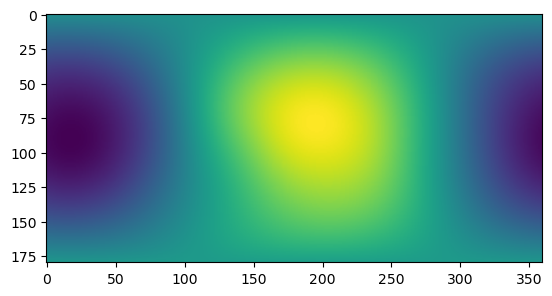

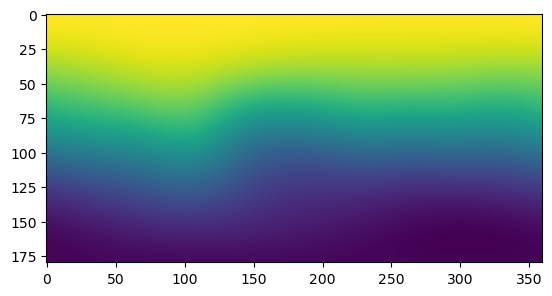

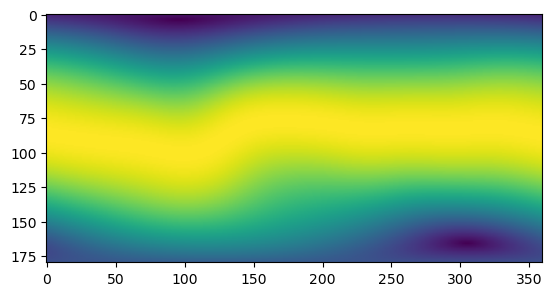

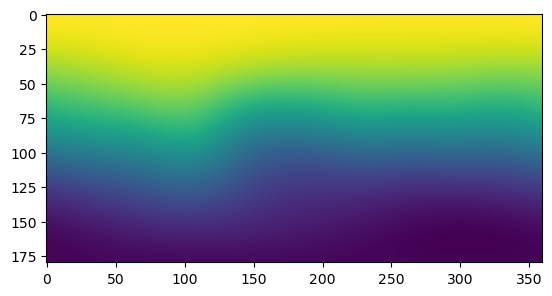

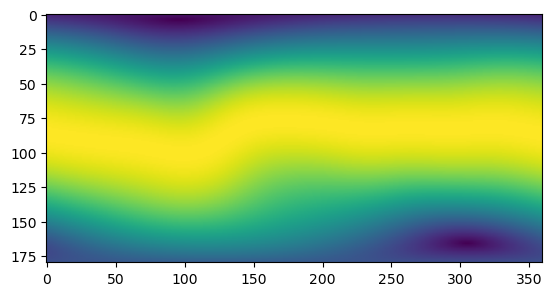

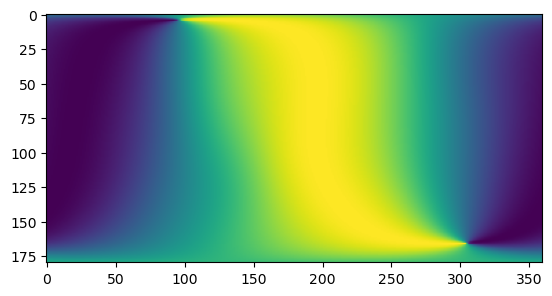

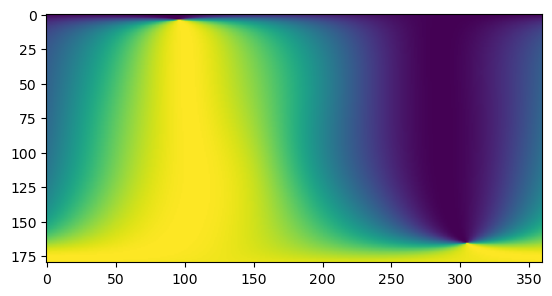

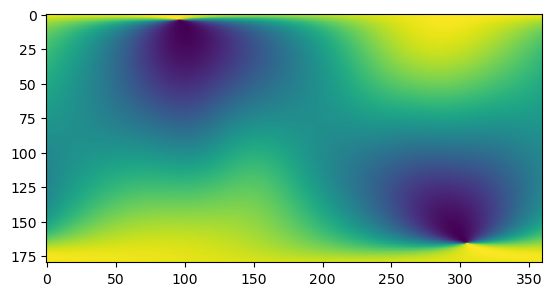

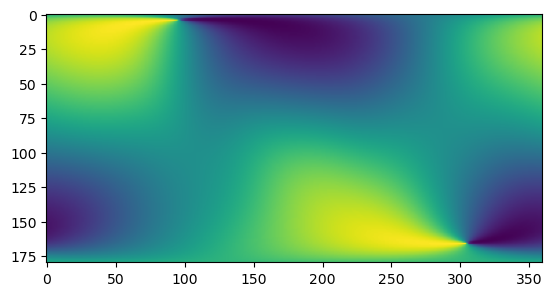

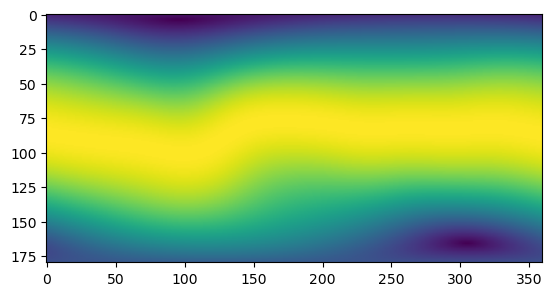

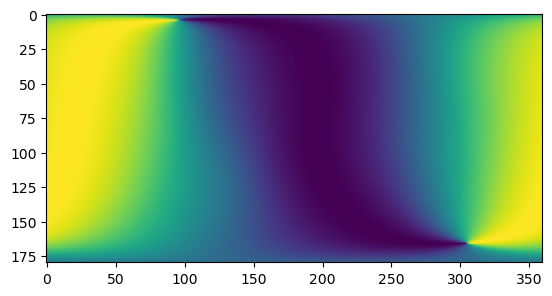

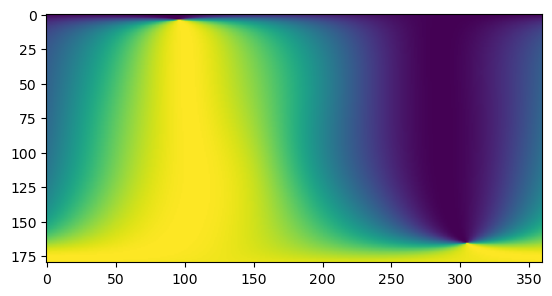

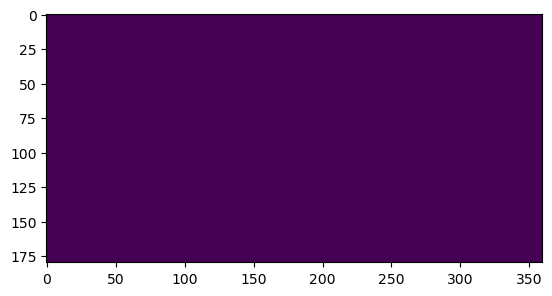

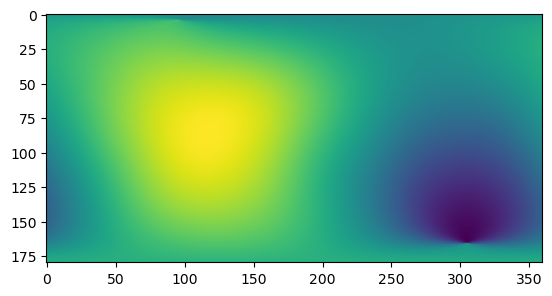

In [20]:
channels = make_positional_channels(lat, lon, K=1, include_tangent=True)

for i, f in enumerate(channels):
    if i == 0:
        summed_f = f
    summed_f += f

    plt.imshow(f)
    plt.show()
    
plt.imshow(summed_f)
plt.show()

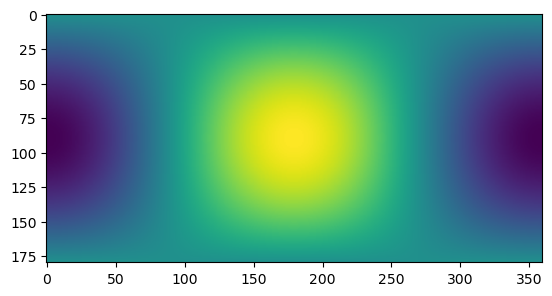

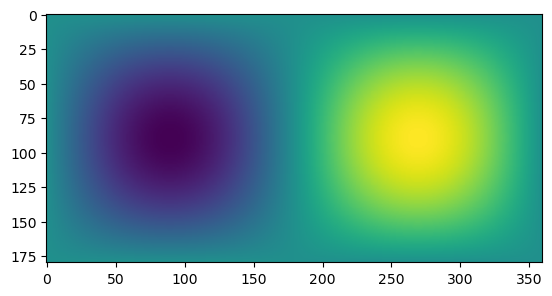

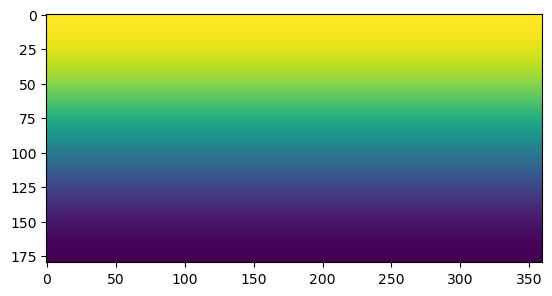

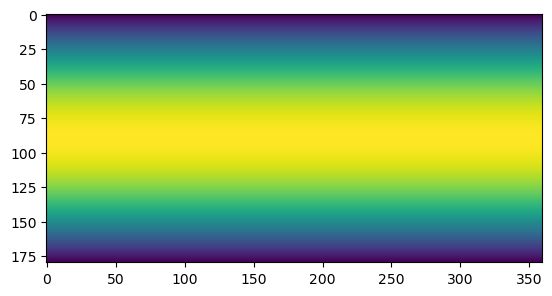

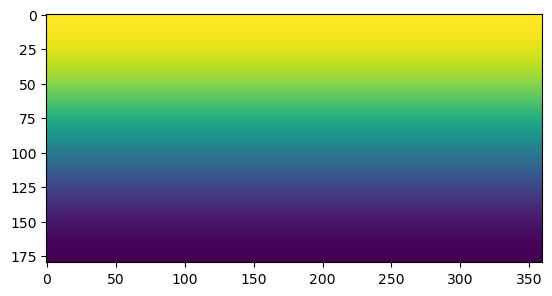

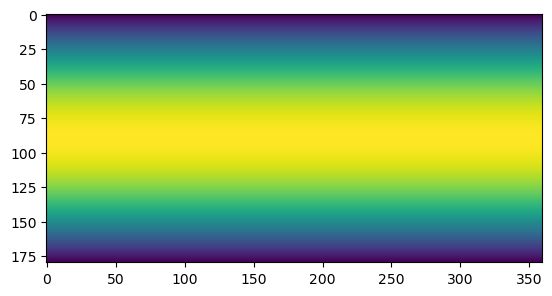

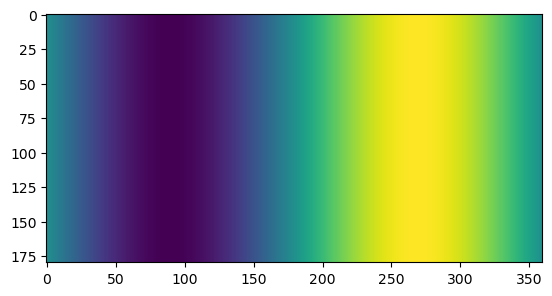

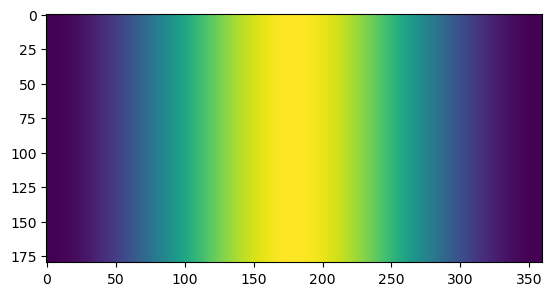

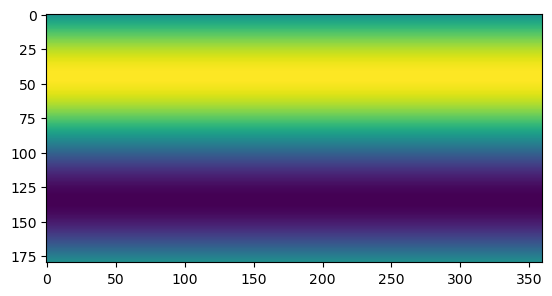

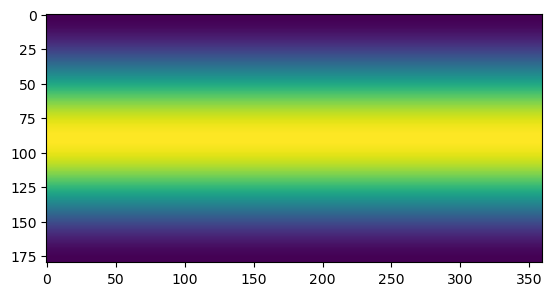

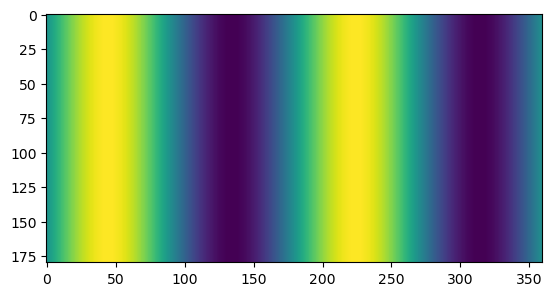

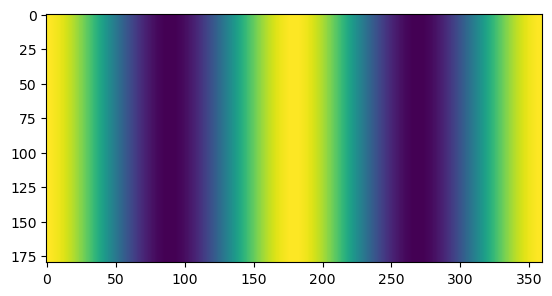

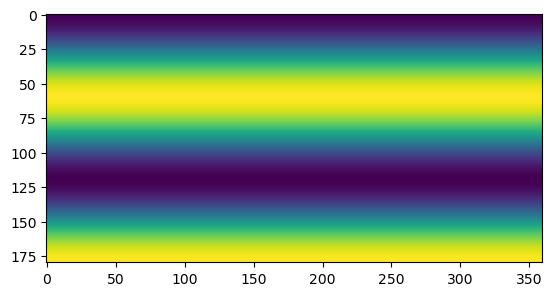

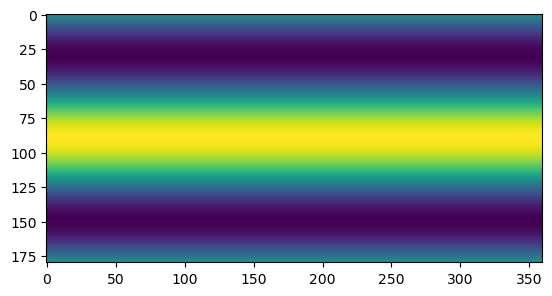

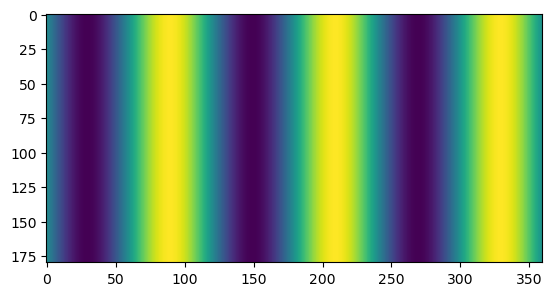

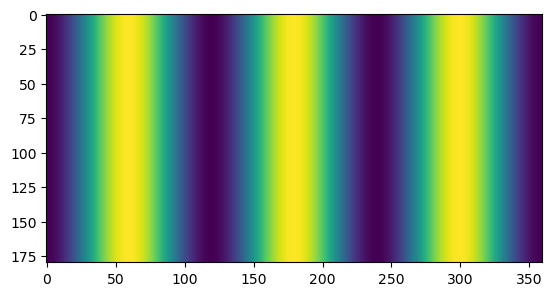

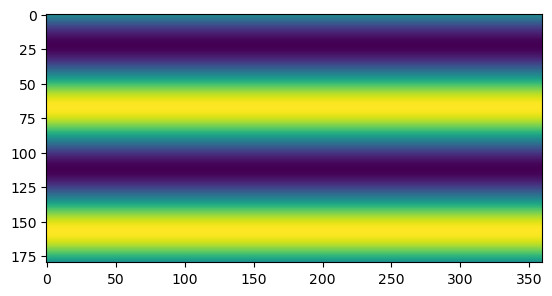

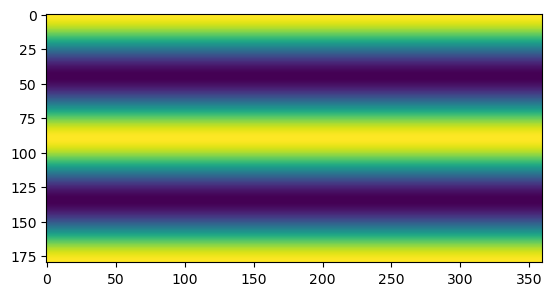

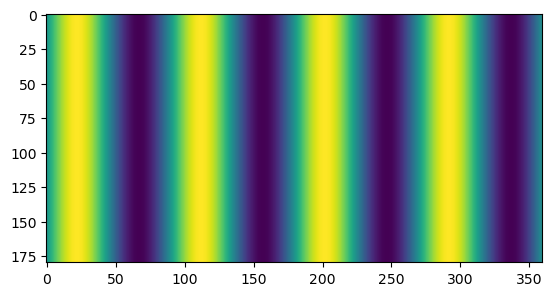

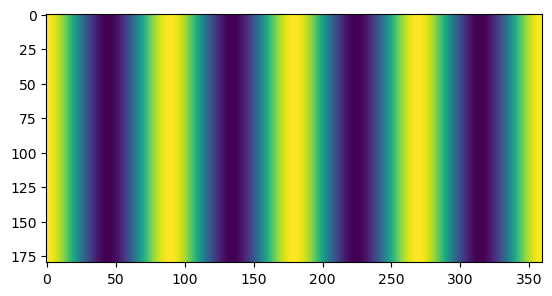

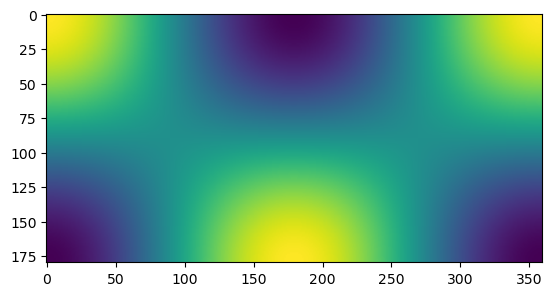

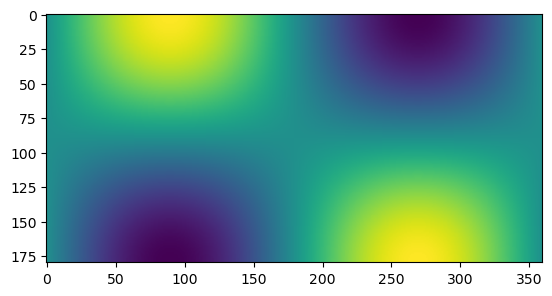

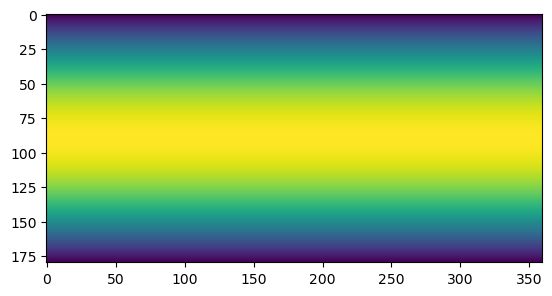

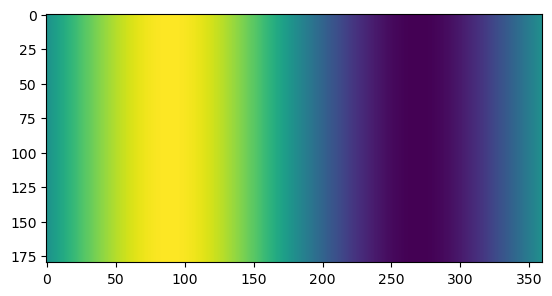

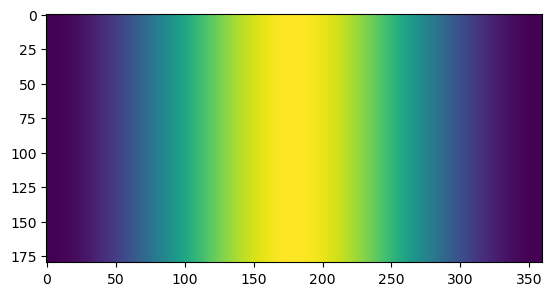

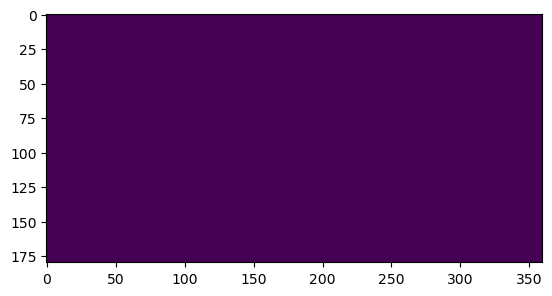

In [12]:
lat_grid = np.linspace(89.5, -89.5, H)[:,None] * np.ones((1,W))   # center-of-cell lat
lon_grid = np.linspace(-179.5, 179.5, W)[None,:] * np.ones((H,1)) # center-of-cell lon
channels = make_positional_channels(lat_grid, lon_grid, K=4, include_tangent=True)

for f in channels:
    plt.imshow(f)
    plt.show()

KeyboardInterrupt: 

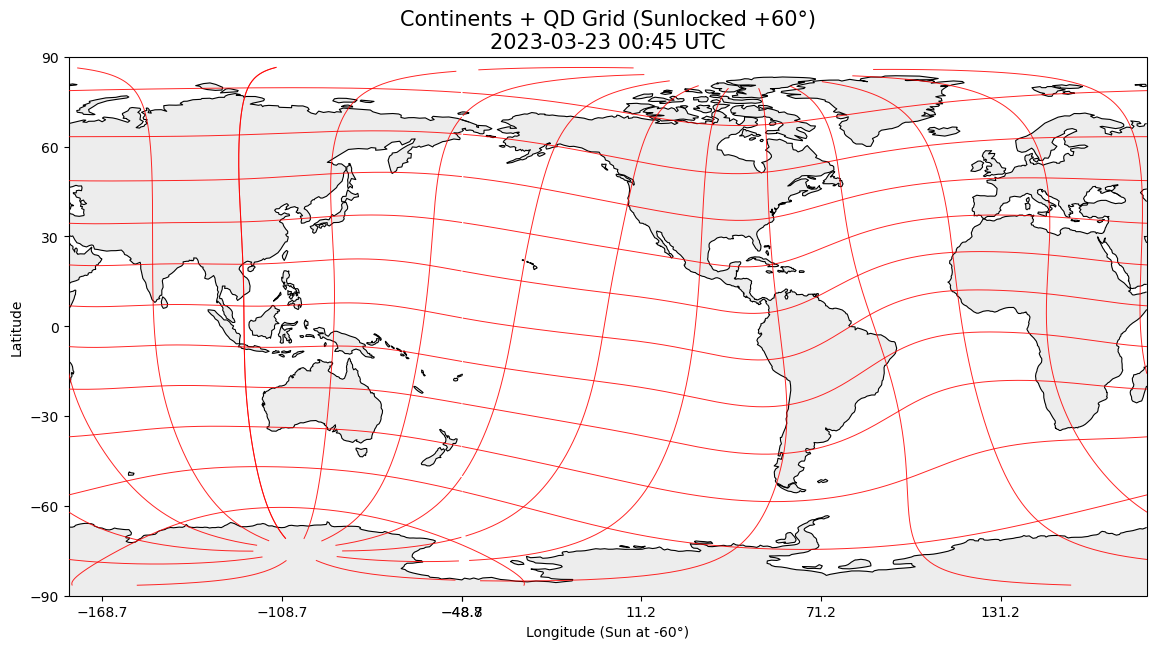

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from apexpy import Apex
import pandas as pd
import warnings


warnings.filterwarnings("ignore", message="invalid value encountered in linestrings")


# --- Time Setup ---
start_dt = pd.to_datetime("2023-03-23T00:00:00")
n_steps = 48 * 4 + 1
dt_list = [start_dt + pd.Timedelta(minutes=15)*i for i in range(n_steps)]

qd_lats = np.arange(-75, 91, 15)
qd_lons = np.arange(-180, 181, 30)

def clean_line_for_plotting(glon, glat, lat_limit=86.5):
    """Insert NaNs where line crosses the latitude limit or has big jumps."""
    # Mask out values near or beyond the lat limit
    mask = (np.abs(glat) < lat_limit) & np.isfinite(glon) & np.isfinite(glat)
    glon = np.where(mask, glon, np.nan)
    glat = np.where(mask, glat, np.nan)
    # Insert NaNs where the difference between adjacent points is too large (avoid wrap lines)
    dlon = np.abs(np.diff(glon))
    jumps = np.where(dlon > 40)[0]  # Threshold can be tuned
    glon = glon.copy()
    glat = glat.copy()
    for j in jumps:
        glon[j+1] = np.nan
        glat[j+1] = np.nan
    return glon, glat

def get_qd_grid_lines(dt, apex_height_km=110):
    apex = Apex(dt.year + (dt.timetuple().tm_yday - 1)/365.25, refh=apex_height_km)
    lines = []
    for qdlon in qd_lons:
        qdlat = np.linspace(-86, 86, 441)
        qdlon_ = np.full_like(qdlat, qdlon)
        glat, glon, _ = apex.qd2geo(qdlat, qdlon_, apex_height_km)
        lines.append(clean_line_for_plotting(glon, glat))
    for qdlat in qd_lats:
        qdlon = np.linspace(-180, 180, 1081)
        qdlat_ = np.full_like(qdlon, qdlat)
        glat, glon, _ = apex.qd2geo(qdlat_, qdlon, apex_height_km)
        lines.append(clean_line_for_plotting(glon, glat))
    return lines

def get_subsolar_lon(dt):
    seconds = dt.hour*3600 + dt.minute*60 + dt.second
    return (seconds / 86400.0)*360.0 - 180.0

fig = plt.figure(figsize=(14, 7))

def update(frame_idx):
    fig.clf()
    dt = dt_list[frame_idx]
    subsolar_lon = get_subsolar_lon(dt)
    center_lon = -(subsolar_lon - 60)
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=center_lon))
    ax.set_global()
    ax.add_feature(cfeature.LAND, facecolor='0.93', zorder=1)
    ax.coastlines(linewidth=0.8, zorder=2)
    # --- QD grid: robust plotting ---
    qd_lines = get_qd_grid_lines(dt)
    for glon, glat in qd_lines:
        ax.plot(glon, glat, color='red', lw=0.7, alpha=0.85,
                transform=ccrs.PlateCarree(), zorder=3)
    ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.set_xlabel('Longitude (Sun at -60°)')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Continents + QD Grid (Sunlocked +60°)\n{dt:%Y-%m-%d %H:%M UTC}', fontsize=15)

ani = animation.FuncAnimation(fig, update, frames=len(dt_list), interval=120, blit=False)
ani.save('final_correct_continents_QD_grid4.gif', writer='pillow', fps=6)
print("Saved final_correct_continents_QD_grid4.gif")